# Step 1: Implement the vector median filter for colour images.

Write a function that implements the vector median filter.  Details on the vector median filter can be found in Topic 4 of the lecture notes and implementation hints are available in the assignment description PDF.   

The parameters to your function should be the input image `I`, and the `radius` of the square neighbourhood, e.g. radius 1 = 3x3 filter, radius 2 = 5x5 filter, etc.

Your function should accept images of dtype `uint8` or `float`.    It is easiest if you work with the image as data type `float`.   If the input image is of type `uint8`, it is suggested that you convert it to dtype `float`, construct the output image also as type `float` and then convert it back to `uint8` before returning it.  In any case, the output image returned should be the same dtype as the input image.

In [1]:
def vector_median(I, radius):
    img_origin_type = I.dtype
    I = util.img_as_float(I)

    n, m, k = I.shape
    l = radius * 2 + 1
    ans = np.zeros((n, m, k))

    for i in range(n):
        for j in range(m):
            window = I.take(
                range(j - radius, j + radius + 1),
                mode='clip',
                axis=1
            ).take(
                range(i - radius, i + radius + 1),
                mode='clip',
                axis=0
            )

            colors = np.reshape(window, (l * l, 3)).transpose()
            Y = np.tile(colors, (l * l, 1, 1)).transpose((2, 1, 0))
            X = np.tile(colors, (l * l, 1, 1))
            
            temp = np.abs(X - Y).sum(axis=0).sum(axis=0)
            ans[i, j, :] = Y[np.argmin(temp), :, 0]
            
    if img_origin_type == "uint8":
        ans = util.img_as_ubyte(ans)
    return ans

# Step 2: Establish a Baseline

Determine the PSNR and SSIM of all of the noisy images by comparing them to their noiseless versions -- store these in a list. 

Filter each noisy image with a 3x3 vector median filter and compute the PSNR and SSIM of all of the filtered noisy images (by comparing them to the noiseless images) -- store these in a list.  

The noiseless images are provided so you can compute PSNR and SSIM.  See functions `skimage.measure.compare_psnr()` and `skimage.measure.compare_ssim()`.  You'll need the `multichannel=true` argument for `compare_ssim()`.

**Important note:** If you are using skimage version 0.18 or higher, you will find that these functions have been moved and renamed to `skimage.metrics.peak_signal_noise_ratio()` and `skimage.metrics.structural_similarity()`, respectively.  It's OK to use these versions of the functions.  Other than the name and module location change, they work the exactly same way as `skimage.measure.compare_psnr()` and `skimage.measure.compare_ssim()`.


_Hint: This step requires doing a few seemingly different things, but it's actually easier to do them all at once in the same loop._


In [8]:
# Some modules you might need.

import skimage.io as io
import os as os
import skimage.filters as filt
import skimage.measure as meas
import skimage.util as util
import numpy as np
import skimage

%matplotlib inline

psnr_noisy = []
ssim_noisy = []
psnr_vmf = []
ssim_vmf = []
psnr_mine = []
ssim_mine = []

# For every file in the noisy images folder...
for root, dirs, files in os.walk('images/noisy'):
    for filename in files:
        # construct the full filename
        noisy_name = os.path.join(root, filename)
        noisless_name = os.path.join("images/noiseless", filename)
        # In case these metadata files show up in the folders, ignore them.
        if filename == '.DS_Store':   
            continue
        # Process image noisy file 'fname' here.  The images have the same filenames name in the 
        # noisy, noisy-test, and noiseless folders.  You'll have to construct the path to the
        # noiseless images yourself.  It's easy using os.path.join(), as above.
        noisy_img = util.img_as_float(io.imread(noisy_name))
        noisless_img = util.img_as_float(io.imread(noisless_name))
        
        vmf_img = vector_median(noisy_img, 1)
        mine_img = my_filter(noisy_img, 1)

        psnr_noisy.append(meas.compare_psnr(noisy_img, noisless_img))
        ssim_noisy.append(meas.compare_ssim(noisy_img, noisless_img, multichannel=True))
        
        psnr_vmf.append(meas.compare_psnr(vmf_img, noisless_img))
        ssim_vmf.append(meas.compare_ssim(vmf_img, noisless_img, multichannel=True))
        
        psnr_mine.append(meas.compare_psnr(mine_img, noisless_img))
        ssim_mine.append(meas.compare_ssim(mine_img, noisless_img, multichannel=True))

# Step 2: Compute average baseline metrics.

Compute the average PSNR and SSIM for the unfiltered noisy images (take the PSNR and SSIM measures for each image and average them).  Do the same for the median-filtered noisy images.  Plot a bar graph showing the two mean PSNR values and another showing the two mean SSIM values before and after filtering (see assignment description for sample output).

([<matplotlib.axis.XTick at 0x18c207b1048>,
 [Text(0.25, 0, 'SSIM Noisy'),
  Text(1.25, 0, 'SSIM Median'),
  Text(2.25, 0, 'SSIM Mine')])

<Figure size 432x288 with 0 Axes>

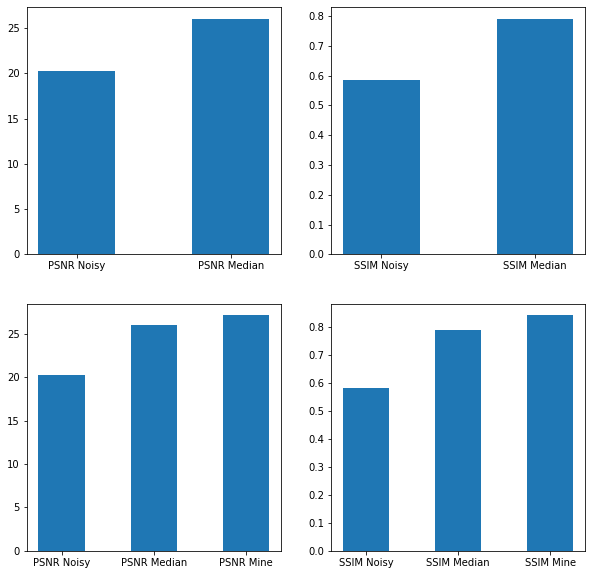

In [9]:
# some modules you might need.

import matplotlib.pyplot as plt
import numpy as np

psnr_noisy_avg = np.mean(psnr_noisy)
ssim_noisy_avg = np.mean(ssim_noisy)

psnr_vmf_avg = np.mean(psnr_vmf)
ssim_vmf_avg = np.mean(ssim_vmf)

psnr_mine_avg = np.mean(psnr_mine)
ssim_mine_avg = np.mean(ssim_mine)

width = 0.5

plt.figure()
plt.subplots(2, 2, figsize=(10, 10))
x = np.arange(width / 2, width * 4, 1)

plt.subplot(2, 2, 1)
plt.bar(x, (psnr_noisy_avg, psnr_vmf_avg), width)
plt.xticks(x, ("PSNR Noisy", "PSNR Median"))

plt.subplot(2, 2, 2)
plt.bar(x, (ssim_noisy_avg, ssim_vmf_avg), width)
plt.xticks(x, ("SSIM Noisy", "SSIM Median"))

x = np.arange(width / 2, width * 6, 1)
plt.subplot(2, 2, 3)
plt.bar(x, (psnr_noisy_avg, psnr_vmf_avg, psnr_mine_avg), width)
plt.xticks(x, ("PSNR Noisy", "PSNR Median", "PSNR Mine"))

plt.subplot(2, 2, 4)
plt.bar(x, (ssim_noisy_avg, ssim_vmf_avg, ssim_mine_avg), width)
plt.xticks(x, ("SSIM Noisy", "SSIM Median", "SSIM Mine"))

# Step 3:  See if you can do better!

Find a better way to denoise the images.  Compute the mean PSNR and SSIM for your denoising method.   Replot the graphs in the previous step with the new results added.

_You can use any functions in the python libraries to help you (numpy, scipy, skimage, etc.) but you cannot bring in code from external sources._


In [2]:
# Write your de-noising method here.
import skimage.restoration as rest

def my_filter(img, radius):
    denoise = vector_median(img, radius)
    denoise = rest.denoise_wavelet(
        denoise,
        multichannel=True, 
        convert2ycbcr=True, 
        method='BayesShrink', 
        mode='soft'
    )
    return denoise